In [331]:
# Imports
import pandas as pd
import numpy as np
import os
from sklearn.metrics import f1_score
import torch
from keras.preprocessing.text import Tokenizer

import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy

In [432]:
# Load data

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

# keep only words_str and sentiment columns
df = df[['words_str', 'sentiment']]
df_test = df_test[['words_str']]
df_test['sentiment'] = ['unknown' for i in range(len(df_test))]

# create train and validation sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# add negative dataset to train set
# negative = pd.read_csv('dataset/Pre-processed_Twitter_tweets/processedNegative.csv').squeeze("columns").T.reset_index()
# negative.columns = ['words_str']
# negative['sentiment'] = ['negative' for i in range(len(negative))]
# print(df_train.shape)
# df_train = pd.concat([df_train, negative], ignore_index=True)
# print(df_train.shape)

# add both train and test sets
df = pd.concat([df, df_test], ignore_index=True)

In [442]:
## Tokenize the sentences
max_features = 6000
# max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df.words_str.values))
print('Found %d unique words.' % len(tokenizer.word_index))
print(f"vocab size: {tokenizer.num_words}")
train_X = tokenizer.texts_to_sequences(df_train.words_str.values)
test_X = tokenizer.texts_to_sequences(df_val.words_str.values)
print(type(train_X))
print(len(train_X))
print(train_X[1])

Found 17132 unique words.
vocab size: 6000
<class 'list'>
6400
[5336, 990, 101, 2867, 129, 7, 376, 1895, 227, 425, 884, 258, 140, 1232, 123, 206, 33, 19, 3237, 2532]


In [443]:
# padding
from keras_preprocessing.sequence import pad_sequences

maxlen = None
# find max length of sentence
maxlen = max([len(s) for s in train_X])

train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [444]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(df_train.sentiment.values)
test_y = le.transform(df_val.sentiment.values)

In [445]:
# handle class imbalancea with SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="minority", random_state=42, k_neighbors=5)

# histogram of class distribution
hist, bins = np.histogram(train_y, bins=3)
print(f'Original class distribution: {hist}')
# train_X, train_y = sm.fit_resample(train_X, train_y) # resample the training set

# # histogram of class distribution
# hist, bins = np.histogram(train_y, bins=3)
# print(f'Resampled class distribution: {hist}')


Original class distribution: [ 395 4200 1805]


In [446]:
embed_size = 300
def load_glove(word_index, embed_size):
    # EMBEDDING_FILE = 'input/glove840b300dtxt/glove.840B.300d.txt'
    # EMBEDDING_FILE = f'models/glove.twitter.27B/glove.twitter.27B.{embed_size}d.txt'
    # EMBEDDING_FILE = f'models/glove.6B/glove.6B.{embed_size}d.txt'
    EMBEDDING_FILE = f'models/glove.840B.300d/glove.840B.{embed_size}d.txt'
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')[:embed_size]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in   open(EMBEDDING_FILE))
    all_embs = np.stack(list(embeddings_index.values()))
    # print(all_embs.mean(), all_embs.std())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    # embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
# emb_mean,emb_std, embed_size = -0.005838499,0.48782197, 200
embedding_matrix = load_glove(tokenizer.word_index, embed_size)

In [447]:
# save embeding matrix
# np.save('embeddings/embedding_matrix_glove_6B_300D_5000.npy', embedding_matrix)
# np.save('embeddings/embedding_matrix_glove_27B_200D_5000.npy', embedding_matrix)
# np.save('embeddings/embedding_matrix_glove_840B_300D_5000.npy', embedding_matrix)
# np.save('embeddings/embedding_matrix_glove_840B_300D_6000.npy', embedding_matrix)
# np.save('embeddings/embedding_matrix_glove_840B_300D_7000.npy', embedding_matrix)

# load embedding matrix
# embedding_matrix = np.load('embeddings/embedding_matrix_glove_6B_300D.npy')
# embedding_matrix = np.load('embeddings/embedding_matrix_glove_27B_200D.npy')
# embedding_matrix = np.load('embeddings/embedding_matrix_glove_840B_300D_5000.npy')
embedding_matrix = np.load('embeddings/embedding_matrix_glove_840B_300D_6000.npy')
# embedding_matrix = np.load('embeddings/embedding_matrix_glove_840B_300D_7000.npy')

In [448]:
class BiLSTM(nn.Module):
    def __init__(self, max_features, embed_size, embedding_matrix, n_classes, hidden_size=64, drp=0.1, num_layers=1):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        if num_layers == 1:
            self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        else:
            self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=drp)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
    def forward(self, x):
        #rint(x.size())*
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))*
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out


In [311]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # List of weights for each class
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            alpha_t = self.alpha[targets.data]
            loss = alpha_t * (1-pt)**self.gamma * ce_loss
        else:
            loss = (1-pt)**self.gamma * ce_loss
        return loss.mean()

In [475]:
n_epochs = 40
batch_size = 32
# embed_size = 200
hidden_size = 300
dropout = 0.3
num_classes = 3
learning_rate = 1e-3
weight_decay = 1e-1
num_layers = 1
model = BiLSTM(max_features=max_features, embed_size=embed_size, hidden_size=hidden_size, drp=dropout, n_classes=num_classes, embedding_matrix=embedding_matrix, num_layers=num_layers)
# loss_fn = nn.CrossEntropyLoss(reduction='sum')
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
loss_fn = nn.CrossEntropyLoss()
# class_count = [395, 4200, 1805]
class_count = [hist[0], hist[1], hist[2]]
alpha = torch.tensor([1.0 / c for c in class_count]).cuda()
alpha = alpha / alpha.sum()
# loss_fn = FocalLoss(alpha=alpha, gamma=5.0)
model.cuda()
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()
# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
train_loss = []
valid_loss = []
training_f1 = []
validation_f1 = []

best_f1 = 0.
best_model = None
best_epoch = 0

start_time = time.time()
for epoch in range(n_epochs):
    # Set model to train configuration
    model.train()
    train_predictions, train_true_labels = [], []  # Store predictions and true labels for F1 score
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        # Get predictions for F1 score calculation
        _, preds = torch.max(y_pred, 1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(y_batch.cpu().numpy())
    avg_loss = avg_loss / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    val_predictions, val_true_labels = [], []  # Store predictions and true labels for F1 score
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            # avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            # val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
            loss_val = loss_fn(y_pred, y_batch)
            avg_val_loss += loss_val.item()
            # Get predictions for F1 score calculation
            _, preds = torch.max(y_pred, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(y_batch.cpu().numpy())
    avg_val_loss = avg_val_loss / len(valid_loader)

    # Check Accuracy
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)

    # Calculate F1 macro scores
    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
    val_f1 = f1_score(val_true_labels, val_predictions, average='macro')
    training_f1.append(train_f1)
    validation_f1.append(val_f1)

    # scheduler.step(avg_val_loss)

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = copy.deepcopy(model)
        best_epoch = epoch
        torch.save(model.state_dict(), 'bi_lstm.pth')

    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t f1={:.4f} \t val_loss={:.4f}  \t val_f1={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, train_f1, avg_val_loss, val_f1, elapsed_time))

print('Best val f1: {:.4f}'.format(best_f1), 'Epoch: {}'.format(best_epoch))

Epoch 1/40 	 loss=0.6665 	 f1=0.4517 	 val_loss=0.5357  	 val_f1=0.4896  	 time=2.27s
Epoch 2/40 	 loss=0.5120 	 f1=0.5835 	 val_loss=0.4738  	 val_f1=0.6165  	 time=4.38s
Epoch 3/40 	 loss=0.4324 	 f1=0.7002 	 val_loss=0.5110  	 val_f1=0.6416  	 time=6.45s
Epoch 4/40 	 loss=0.3485 	 f1=0.7714 	 val_loss=0.4677  	 val_f1=0.6783  	 time=8.51s
Epoch 5/40 	 loss=0.2575 	 f1=0.8416 	 val_loss=0.4963  	 val_f1=0.6872  	 time=10.54s
Epoch 6/40 	 loss=0.1532 	 f1=0.9074 	 val_loss=0.5554  	 val_f1=0.6961  	 time=12.56s
Epoch 7/40 	 loss=0.0895 	 f1=0.9467 	 val_loss=0.6317  	 val_f1=0.6958  	 time=14.58s
Epoch 8/40 	 loss=0.0635 	 f1=0.9622 	 val_loss=0.6624  	 val_f1=0.6903  	 time=16.56s
Epoch 9/40 	 loss=0.0443 	 f1=0.9786 	 val_loss=0.7904  	 val_f1=0.6951  	 time=18.58s
Epoch 10/40 	 loss=0.0336 	 f1=0.9803 	 val_loss=0.8160  	 val_f1=0.6987  	 time=20.70s
Epoch 11/40 	 loss=0.0496 	 f1=0.9779 	 val_loss=0.7213  	 val_f1=0.7135  	 time=22.92s
Epoch 12/40 	 loss=0.0311 	 f1=0.9875 	 val_l

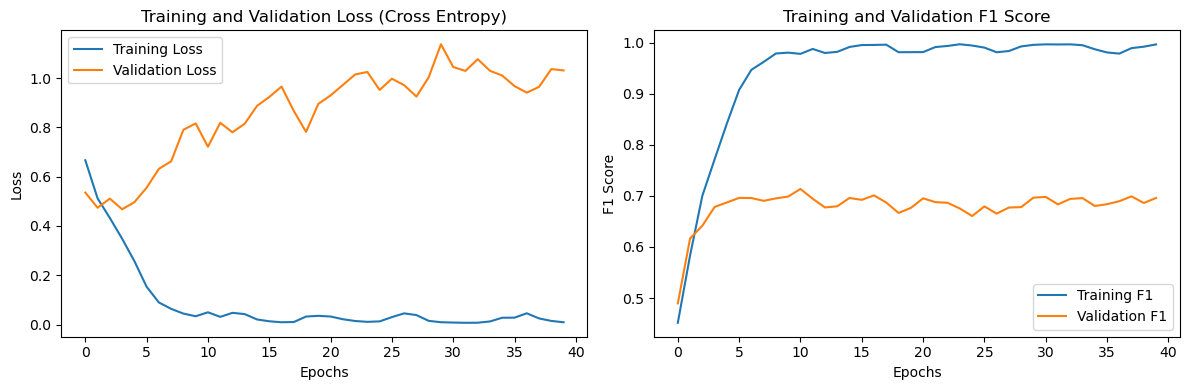

In [476]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss (MSE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.title('Training and Validation Loss (Cross Entropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(training_f1, label='Training F1')
plt.plot(validation_f1, label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [479]:
# load model
embed_size = 300
hidden_size = 300
dropout = 0.3
num_classes = 3
num_layers = 1
max_features = 6000
batch_size = 32

model = BiLSTM(max_features=max_features, embed_size=embed_size, hidden_size=hidden_size, drp=dropout, n_classes=num_classes, embedding_matrix=embedding_matrix, num_layers=num_layers)
model.load_state_dict(torch.load('models/bi_lstm_mf6000_es300_840B_h300_d0.3_nl1_test_included.pth'))
model.cuda()
# model = best_model

# check on validation set
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()
valid = torch.utils.data.TensorDataset(x_cv, y_cv)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

# model.eval()
# valid_preds = np.zeros((len(test_X)))
# for i, (x_batch, _) in enumerate(valid_loader):
#     y_pred = model(x_batch).detach()
#     valid_preds[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy().argmax(axis=1)

model.eval()        
avg_val_loss = 0.
val_preds = np.zeros((len(x_cv),len(le.classes_)))
val_predictions, val_true_labels = [], []  # Store predictions and true labels for F1 score
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        model.lstm.flatten_parameters()
        y_pred = model(x_batch).detach()
        # Get predictions for F1 score calculation
        _, preds = torch.max(y_pred, 1)
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(y_batch.cpu().numpy())

# compute f1 score
print('f1 score: ', f1_score(val_true_labels, val_predictions, average='macro'))
print(classification_report(val_true_labels, val_predictions, target_names=le.classes_))


f1 score:  0.7134984607836702
              precision    recall  f1-score   support

    negative       0.57      0.47      0.52        87
     neutral       0.85      0.93      0.89      1090
    positive       0.83      0.66      0.73       423

    accuracy                           0.83      1600
   macro avg       0.75      0.69      0.71      1600
weighted avg       0.83      0.83      0.83      1600



In [480]:
temp_y = df_val.sentiment.values
le.fit(temp_y)
temp_y = le.transform(temp_y)

print(classification_report(temp_y, val_predictions, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.57      0.47      0.52        87
     neutral       0.85      0.93      0.89      1090
    positive       0.83      0.66      0.73       423

    accuracy                           0.83      1600
   macro avg       0.75      0.69      0.71      1600
weighted avg       0.83      0.83      0.83      1600

